In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import datetime, timedelta

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
model_name = 'ecmwfsipn'
model_type = 'forecast'
filepath = '/home/disk/sipn/nicway/data/model/{model_name}/{model_type}/sipn_nc/'.format(model_name=model_name,
                                              model_type=model_type)
filenames = xr.open_mfdataset(filepath+'/*.nc',concat_dim='init_time')
print(filenames)

<xarray.Dataset>
Dimensions:    (ensemble: 51, fore_time: 215, init_time: 25, ni: 448, nj: 304)
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 1 days 2 days ... 214 days 215 days
    lon        (nj, ni) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (nj, ni) float64 31.1 31.25 31.4 31.55 ... 34.77 34.62 34.47
  * ensemble   (ensemble) int32 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * init_time  (init_time) datetime64[ns] 2017-11-01 2017-12-01 ... 2019-11-01
Dimensions without coordinates: ni, nj
Data variables:
    sic        (init_time, ensemble, fore_time, nj, ni) float64 dask.array<shape=(25, 51, 215, 304, 448), chunksize=(1, 51, 215, 304, 448)>


In [3]:
init_times = filenames.init_time
forecast_times = filenames.fore_time
extent = filenames.sic
lat = filenames.lat
lon = filenames.lon
chunk_sizes = filenames['sic'].shape
#print(chunk_sizes)

In [4]:
no_ens = len(filenames.ensemble) ##no. of ensemble members
no_forecast_periods = len(forecast_times)

In [5]:
#for itime in np.arange(0,init_time):
itime = 0
init_times_df = pd.DatetimeIndex(init_times.values)
init_select = init_times_df[itime]
d_SIC_lead_time = pd.DataFrame({"I (init date)":pd.Series(init_select).repeat(len(forecast_times)*no_ens),
                                    "V (valid date)":"",
                                    "V_mon (valid date month)":"",
                                    "V_yr (valid date year)":"",
                                    "lead time (days)":"",
                                    "ensemble":""})

In [6]:
for iens in np.arange(0,no_ens):
            #iens = 0
            ##Keep track of the correct indices so we don't have to append ad infitum
            save_ind = iens*(no_forecast_periods) + np.arange(0,no_forecast_periods)
            #Subset our sea ice extent by init_tim, ensemble no., and region
            I_test = extent[itime,iens,:,:,:]
            ##since we're doing 5-day means, our first and last 2 dates aren't included
            ind_select = np.arange(0,no_forecast_periods) 
            ##Now, we get the dates that correspond to our valid date and number of lead days
            forecast_dates = ind_select.astype('timedelta64[D]')
            date_change = pd.Series(init_select).repeat(len(forecast_dates)) + forecast_dates
            d_SIC_lead_time['V (valid date)'].iloc[save_ind] = pd.to_datetime(date_change.values)
            d_SIC_lead_time['V_mon (valid date month)'].iloc[save_ind] = pd.to_datetime(date_change.values).month
            d_SIC_lead_time['V_yr (valid date year)'].iloc[save_ind] = pd.to_datetime(date_change.values).year
            ##We want to save lead time as a time delta, not a date
            d_SIC_lead_time["lead time (days)"].iloc[save_ind] = pd.to_timedelta(forecast_dates).days
            ##This is just for saving files, because Python is 0-indexed but our ensemble no isn't
            ens_no = iens + 1
            ##Save info about our ensemble, region, and raw SIE data
            d_SIC_lead_time['ensemble'].iloc[save_ind] = np.tile(ens_no,len(ind_select))
            #d_SIC_lead_time['region'].iloc[save_ind] = np.tile(region_name,len(delta_extent))
            #d_SIC_lead_time['SIE'].iloc[save_ind] = I_test[ind_select]

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
sic = extent
sic_sel = sic.sel(init_time = '2018-01-01T00:00:00.000000000',fore_time=forecast_times[0])
sic_sel.shape

(51, 304, 448)

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


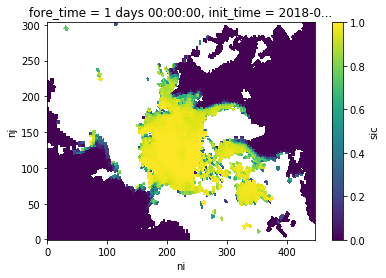

In [8]:
sic_sel.mean(dim='ensemble').plot()


In [9]:
obs_fpath = '/home/disk/sipn/nicway/data/obs/NSIDC_0079/sipn_nc_yearly/'
filenames_obs = xr.open_dataset(obs_fpath+'2018.nc')
print(filenames)

<xarray.Dataset>
Dimensions:    (ensemble: 51, fore_time: 215, init_time: 25, ni: 448, nj: 304)
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 1 days 2 days ... 214 days 215 days
    lon        (nj, ni) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (nj, ni) float64 31.1 31.25 31.4 31.55 ... 34.77 34.62 34.47
  * ensemble   (ensemble) int32 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * init_time  (init_time) datetime64[ns] 2017-11-01 2017-12-01 ... 2019-11-01
Dimensions without coordinates: ni, nj
Data variables:
    sic        (init_time, ensemble, fore_time, nj, ni) float64 dask.array<shape=(25, 51, 215, 304, 448), chunksize=(1, 51, 215, 304, 448)>


In [11]:
sic_obs = filenames_obs['sic']
obs_time = filenames_obs['time']
sic_obs
obs_time_mon = obs_time.dt.month
f_time = np.where(obs_time_mon == 1)
f_time[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'model')

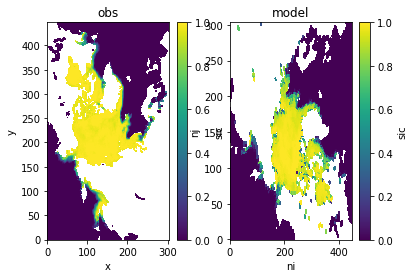

In [12]:
sic_obs_sel = sic_obs.isel(time=f_time[0])
sic_obs_sel.shape
fig, axes = plt.subplots(ncols=2)
sic_obs_sel.mean(axis=0).plot(ax=axes[0])
axes[0].set_title('obs')
sic_sel.mean(dim='ensemble').plot(ax=axes[1])
axes[1].set_title('model')

In [15]:
sic_obs_MEAN = sic_obs_sel.mean(axis=0)
sic_model_MEAN = sic_sel.mean(dim='ensemble')
DIFF = sic_model_MEAN - sic_obs_MEAN.transpose()
DIFF.shape

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(304, 448, 304, 448)

In [ ]:
DIFF.plot()